In [1]:
# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)


import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm

In [2]:
plt.style.use('plot_style-Examples.txt')

# 16:9 aspect ratio
width = 16
height = width * 9 / 16

In [185]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 500)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])

In [249]:

def generate_white_noise(T, h,stiffess_matrix, key):
    L_L2 = scipy.linalg.cholesky(stiffess_matrix)
    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)

    N_basis = L_L2.shape[0]

    noise = []
    y = 0
    for i in range(N):
        key, subkey = random.split(key)
        # Sample from the space time white noise
        xi =  L_L2@random.normal(subkey, (N_basis,))
        noise.append(xi)

        #y = y + jnp.sqrt(h)*xi
        #print(y.shape)
    
    return jnp.array(noise), time

@jit
def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values

vmap_evalute_function = jit(vmap(evaluate_function, in_axes = (None, 0, None)))

In [250]:
N_basis = 10
stiffess_matrix_spectral = jnp.eye(N_basis)

In [251]:
h = 0.001
T = 1
noise_coef, time_span = generate_white_noise(T, h, stiffess_matrix_spectral, random.PRNGKey(0))

In [252]:
wiener_process = jnp.cumsum(vmap_evalute_function(x, noise_coef, L)*jnp.sqrt(h), axis =0)
noise_time =vmap_evalute_function(x, noise_coef, L)*jnp.sqrt(h)

In [255]:
# Reset to default style
plt.style.use('default')

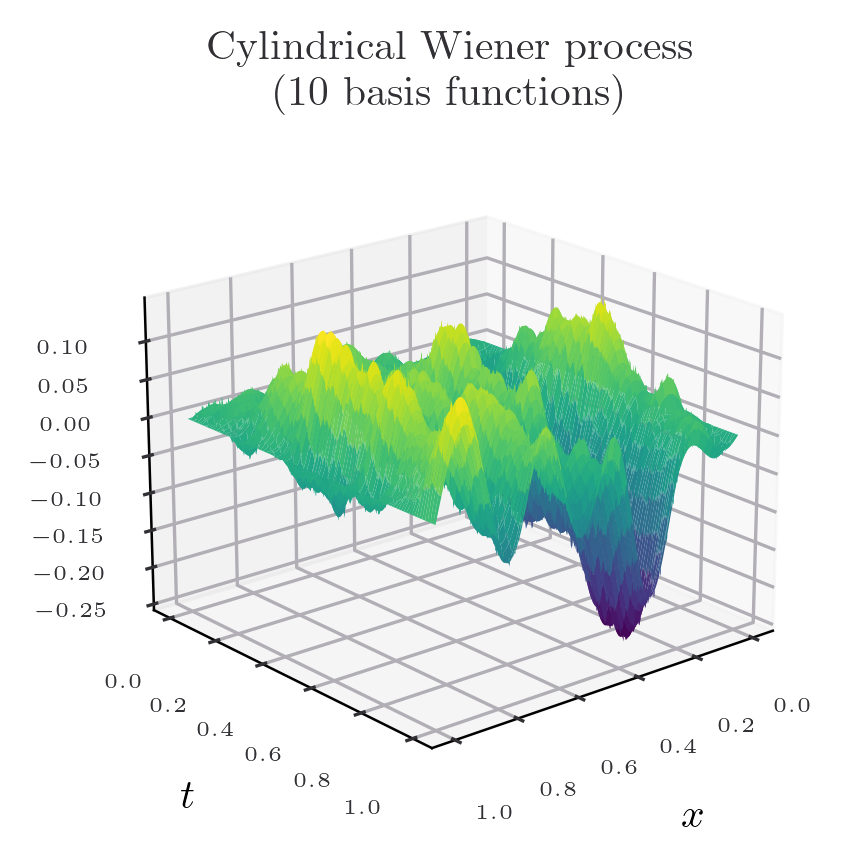

In [278]:
plt.style.use('plot_style-Examples_3d.txt')
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

stride = 10
# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span)
ax.plot_surface(X, Y, wiener_process,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title('Cylindrical Wiener process \n ({} basis functions)'.format(N_basis))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
#plt.savefig('figures/white_noise/st_wn.png', bbox_inches = 'tight')
plt.show()

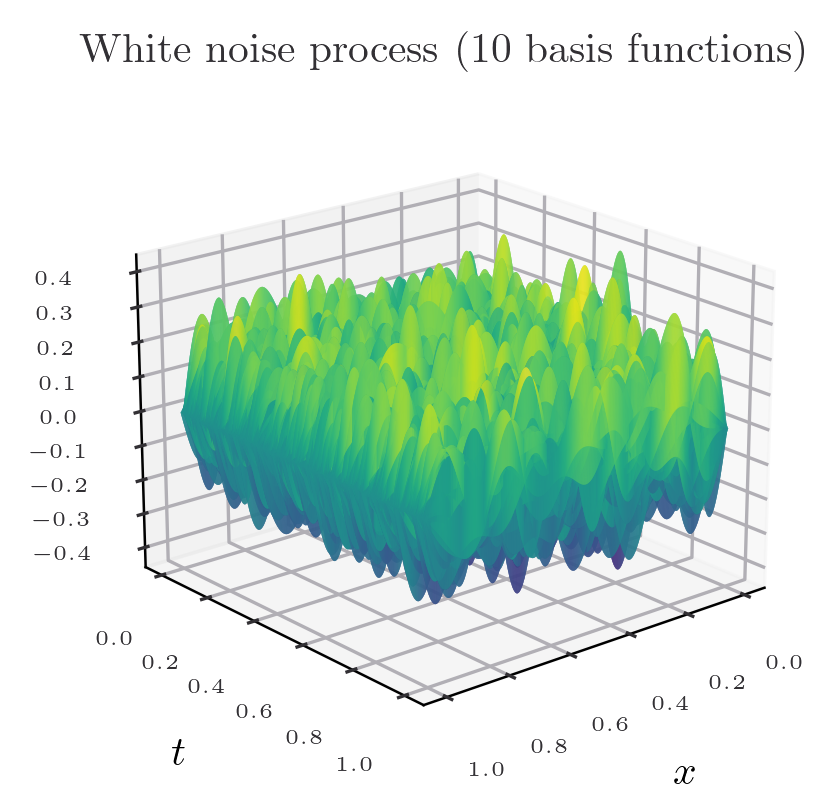

In [269]:
plt.style.use('plot_style-Examples_3d.txt')
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span)
a = 1
ax.plot_surface(X, Y, noise_time,  cmap='viridis', rstride=a, cstride=a)
ax.set_title('White noise process ({} basis functions)'.format(N_basis))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

# Generate white noise for higher number of basis functions

Number of basis functions: 10


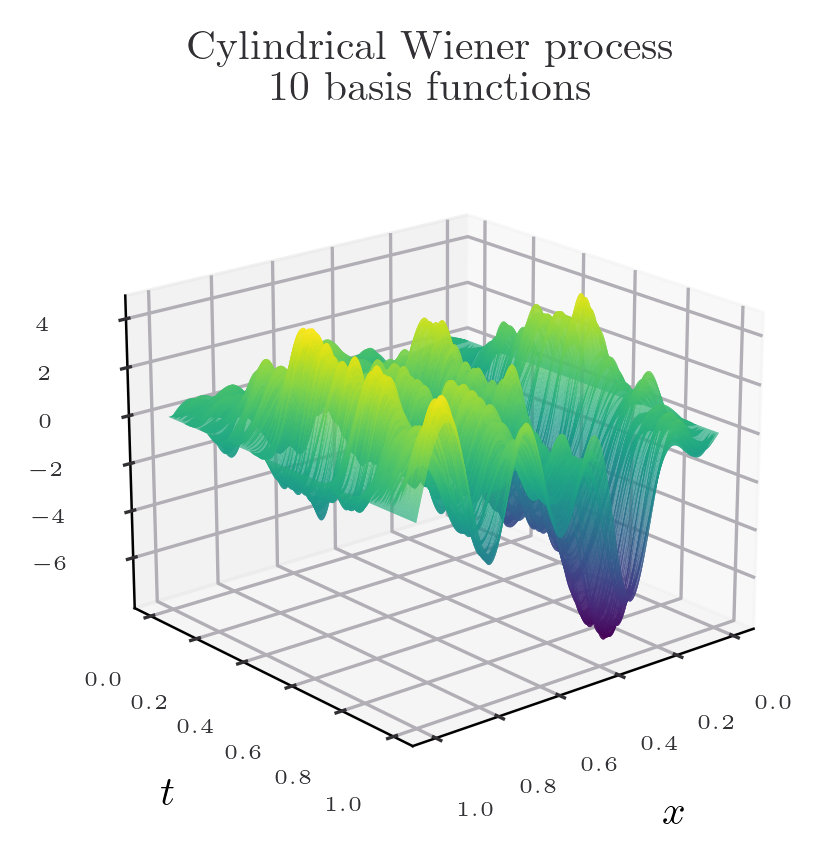

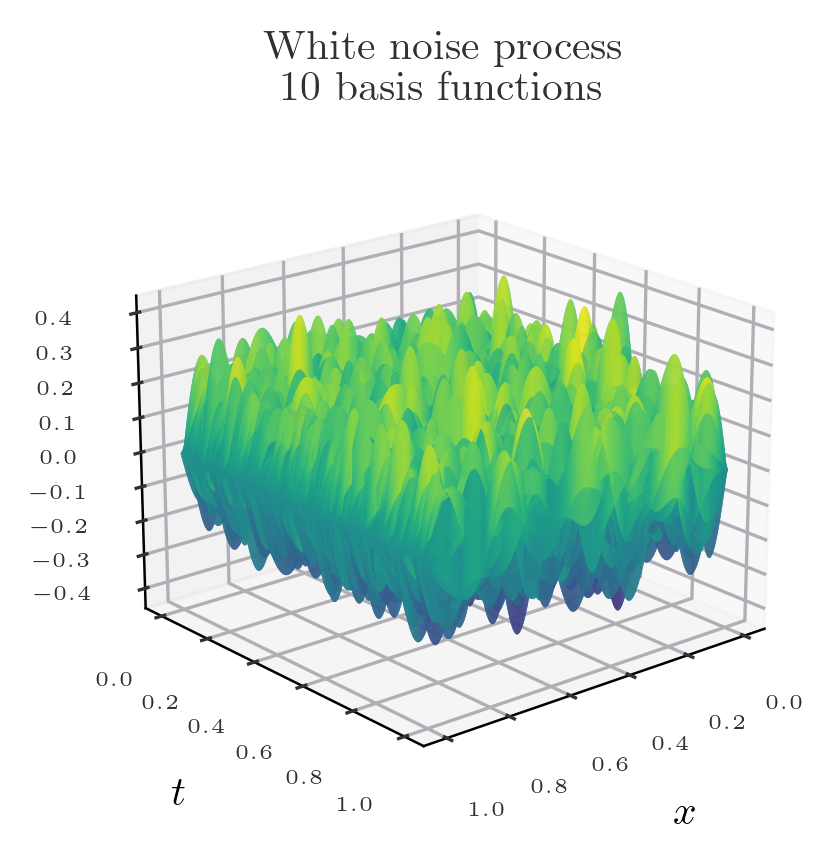

Number of basis functions: 50


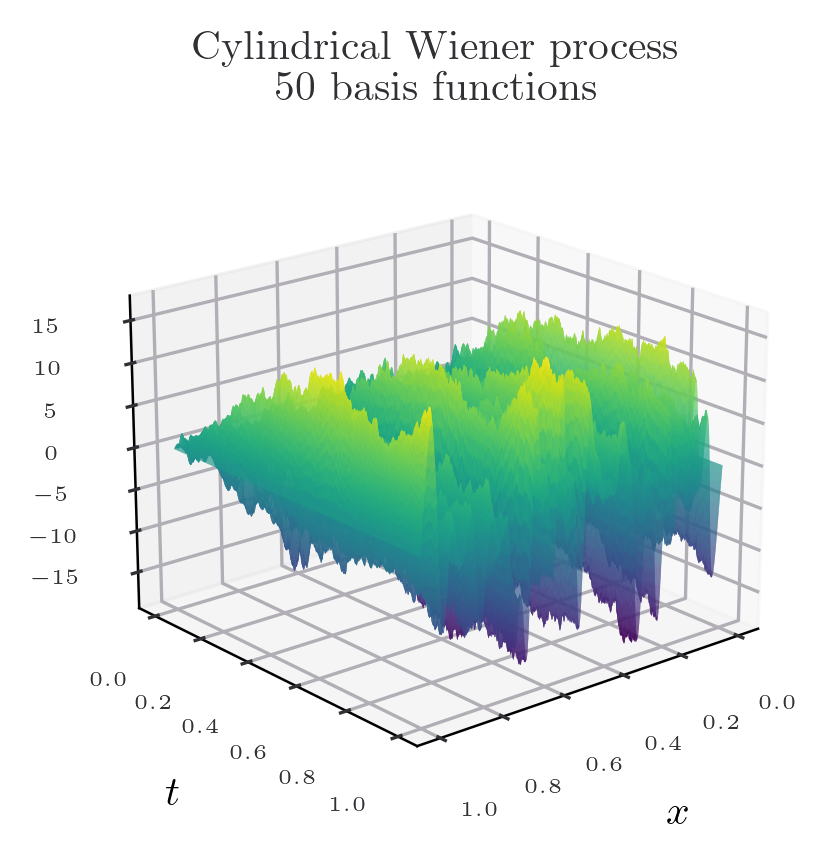

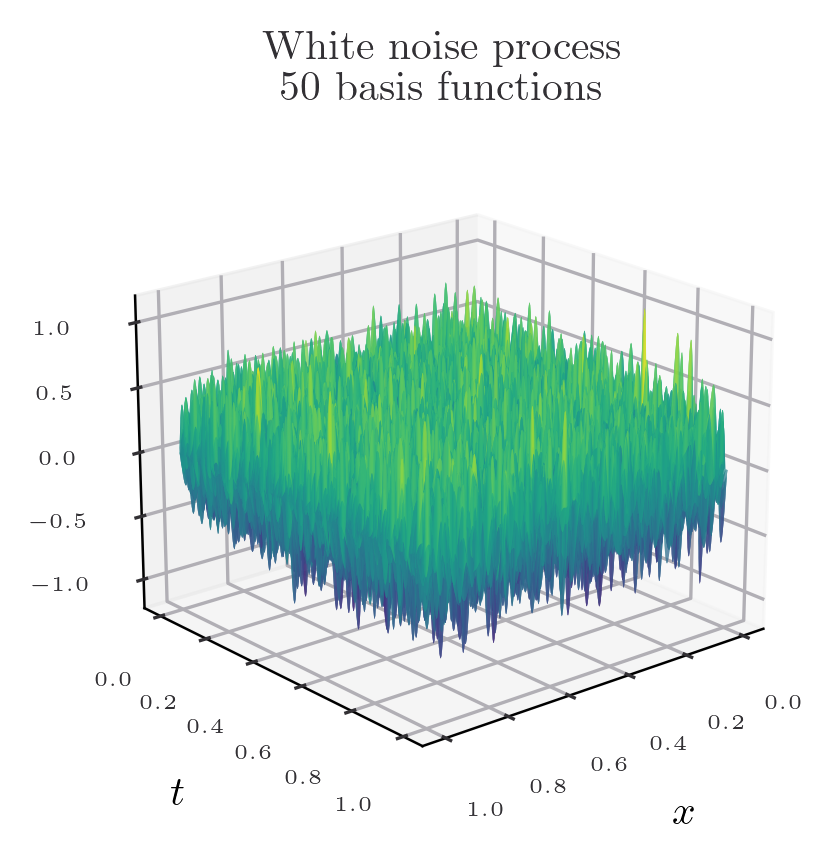

Number of basis functions: 100


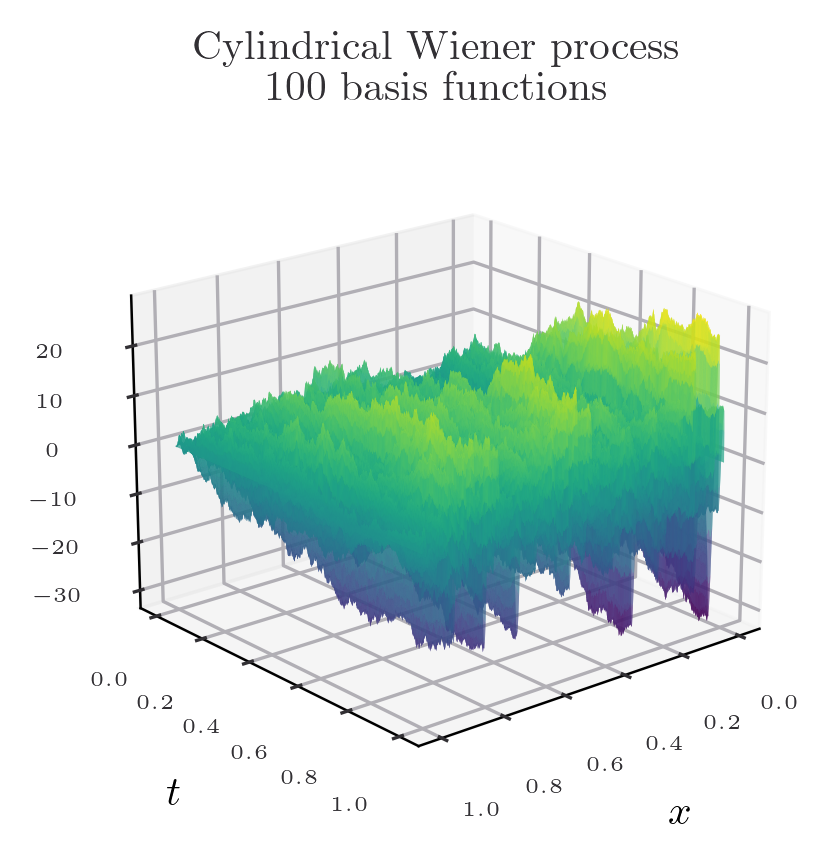

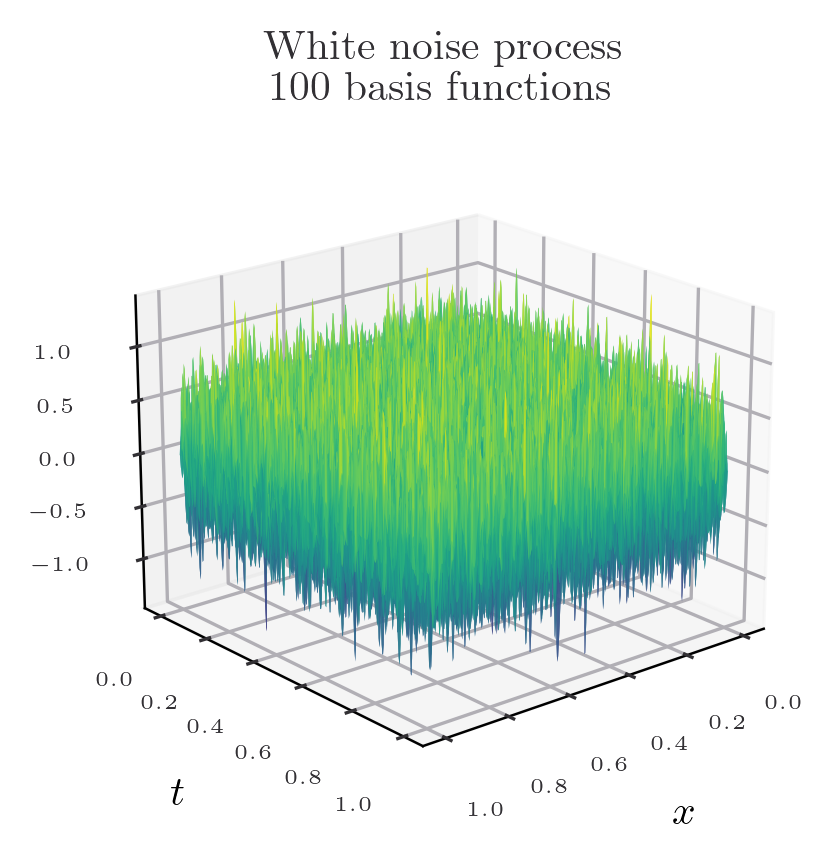

In [286]:
basis_number = [10, 50, 100]
h = 0.001
T = 1

stride = 1 # Stride for the surface plot
for N_basis in basis_number:
    print('Number of basis functions: {}'.format(N_basis))
    stiffess_matrix_spectral = jnp.eye(N_basis)
    # Sample white noise
    noise_coef, time_span = generate_white_noise(T, h, stiffess_matrix_spectral, random.PRNGKey(0))
    
    white_noise =vmap_evalute_function(x, noise_coef, L)*jnp.sqrt(h)
    wiener_process = jnp.cumsum(white_noise, axis =0)

    # Create plots
    fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

    # Surface plot on the first axis
    X, Y = jnp.meshgrid(x, time_span)
    ax.plot_surface(X, Y, wiener_process,  cmap='viridis', rstride=stride, cstride=stride)
    ax.set_title('Cylindrical Wiener process \n {} basis functions'.format(N_basis))
    ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    plt.savefig('figures/white_noise/wiener_process_{}.png'.format(N_basis), bbox_inches = 'tight')
    plt.show()

    fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

    # Surface plot on the first axis
    X, Y = jnp.meshgrid(x, time_span)
    ax.plot_surface(X, Y, white_noise,  cmap='viridis', rstride=stride, cstride=stride)
    ax.set_title('White noise process \n {} basis functions'.format(N_basis))
    ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    plt.savefig('figures/white_noise/white_poise_{}.png'.format(N_basis), bbox_inches = 'tight')
    plt.show()




    

# Using a tent function basis

In [287]:
n_meas = 10
m_tool = measurement_tool(domain, n_meas)

In [288]:
h = 0.001
T = 1
noise_coef, time_span = generate_white_noise(T, h, m_tool.L_2, random.PRNGKey(0))

In [320]:
from utils_rough_pde import vmap_tent_evaluate, evaluate_tent, vmap_tent_vector
evaluate_tent_time = jit(vmap(evaluate_tent, in_axes = (0, None, None, None)))
evaluate_tent(noise_coef[0], x, m_tool.epsilon, m_tool.centers)
evaluate_tent_time(noise_coef, x, m_tool.epsilon, m_tool.centers)

Array([[ 0.00000000e+00,  5.88563974e-01,  1.17712795e+00, ...,
        -9.73759071e-01, -4.86879535e-01, -5.39463781e-15],
       [ 0.00000000e+00, -2.98264381e-01, -5.96528763e-01, ...,
         1.25963356e-01,  6.29816779e-02,  6.97838615e-16],
       [ 0.00000000e+00,  1.03378436e+00,  2.06756873e+00, ...,
         4.63945591e-01,  2.31972796e-01,  2.57026456e-15],
       ...,
       [ 0.00000000e+00,  1.12752474e+00,  2.25504948e+00, ...,
         1.06268467e+00,  5.31342336e-01,  5.88728678e-15],
       [ 0.00000000e+00,  3.75933844e-02,  7.51867688e-02, ...,
        -5.15887465e-01, -2.57943733e-01, -2.85802321e-15],
       [ 0.00000000e+00,  5.67076526e-02,  1.13415305e-01, ...,
         1.70169298e+00,  8.50846491e-01,  9.42740106e-15]],      dtype=float64)

In [319]:
white_noise = evaluate_tent_time(noise_coef, x, m_tool.epsilon, m_tool.centers)*jnp.sqrt(h)
wiener_process = jnp.cumsum(white_noise, axis =0)

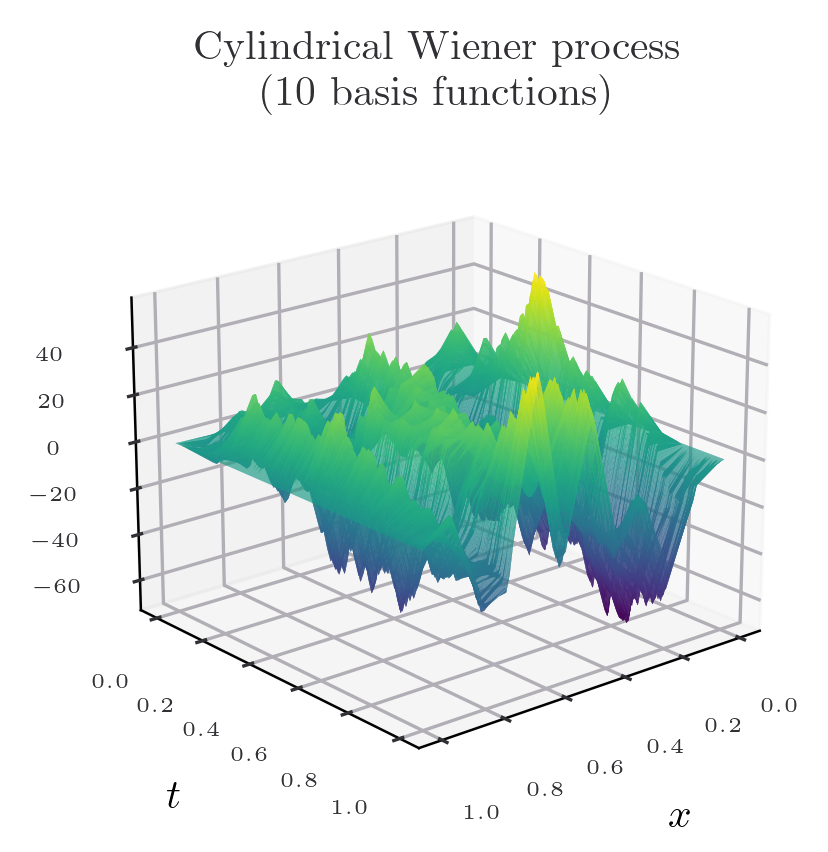

In [325]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

stride = 1
# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span)
ax.plot_surface(X, Y, wiener_process,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title('Cylindrical Wiener process \n ({} basis functions)'.format(n_meas))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

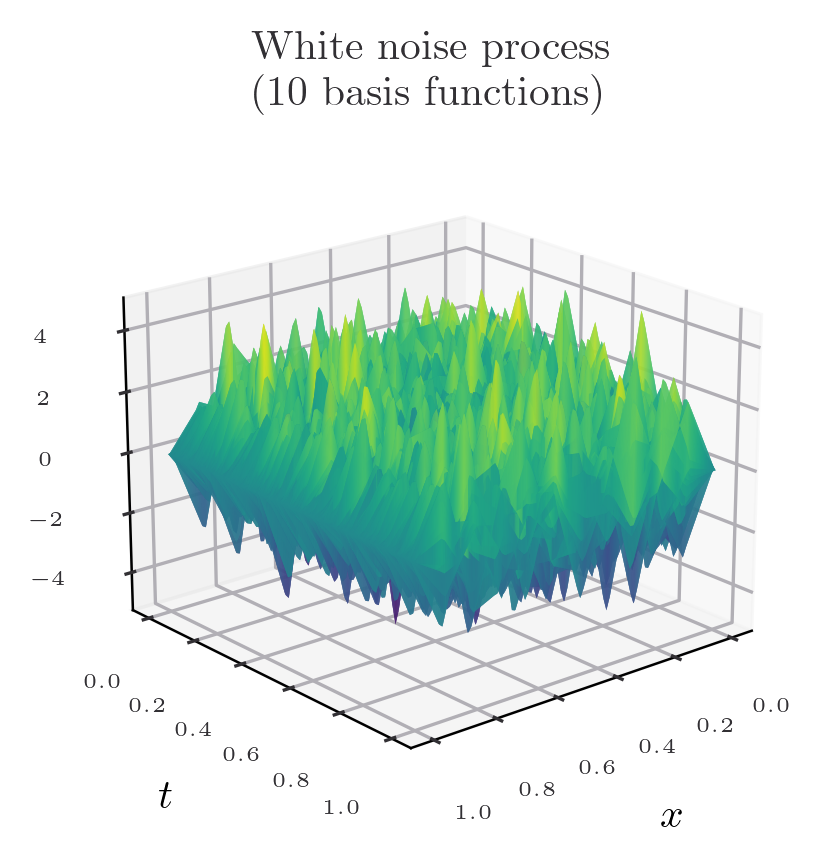

In [324]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

stride = 1
# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span)
ax.plot_surface(X, Y, white_noise,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title('White noise process \n ({} basis functions)'.format(n_meas))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

In [326]:
basis_number = [10, 50, 100]
h = 0.001
T = 1

stride = 1 # Stride for the surface plot
for N_basis in basis_number:
    print('Number of basis functions: {}'.format(N_basis))

    m_tool = measurement_tool(domain, N_basis)
    # Sample white noise
    noise_coef, time_span = generate_white_noise(T, h, m_tool.L_2, random.PRNGKey(0))
    
    white_noise = evaluate_tent_time(noise_coef, x, m_tool.epsilon, m_tool.centers)*jnp.sqrt(h)
    wiener_process = jnp.cumsum(white_noise, axis =0)

    # Create plots
    fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

    # Surface plot on the first axis
    X, Y = jnp.meshgrid(x, time_span)
    ax.plot_surface(X, Y, wiener_process,  cmap='viridis', rstride=stride, cstride=stride)
    ax.set_title('Cylindrical Wiener process \n {} basis functions'.format(N_basis))
    ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    plt.savefig('figures/white_noise/tent_wiener_process_{}.png'.format(N_basis), bbox_inches = 'tight')
    plt.show()

    fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

    # Surface plot on the first axis
    X, Y = jnp.meshgrid(x, time_span)
    ax.plot_surface(X, Y, white_noise,  cmap='viridis', rstride=stride, cstride=stride)
    ax.set_title('White noise process \n {} basis functions'.format(N_basis))
    ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    plt.savefig('figures/white_noise/tent_white_poise_{}.png'.format(N_basis), bbox_inches = 'tight')
    plt.show()




    

Number of basis functions: 10


# Old code

In [210]:
def generate_white_noise(T, h,stiffess_matrix, key):
    L_L2 = scipy.linalg.cholesky(stiffess_matrix)
    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)

    N_basis = L_L2.shape[0]

    noise = []
    noise_coef = []
    y = jnp.zeros(shape = (len(x),))
    for i in range(N):
        key, subkey = random.split(key)
    
        # Sample from the space time white noise
        xi =  random.normal(subkey, (N_basis,))
        noise_coef.append(xi)

        y = y + jnp.sqrt(h)*evaluate_function(x, xi, L)
        noise.append(y)

        #print(y.shape)
    
    return jnp.array(noise), jnp.array(noise_coef), time

In [211]:
wiener_process, noise_coef, time_span = generate_white_noise(T, h, stiffess_matrix_spectral, random.PRNGKey(0))

In [212]:
wiener_process.shape

(1000, 500)

In [213]:
x.shape

(500,)

In [214]:
white_noise = wiener_process[1:] - wiener_process[:-1]

In [215]:
white_noise.shape

(999, 500)

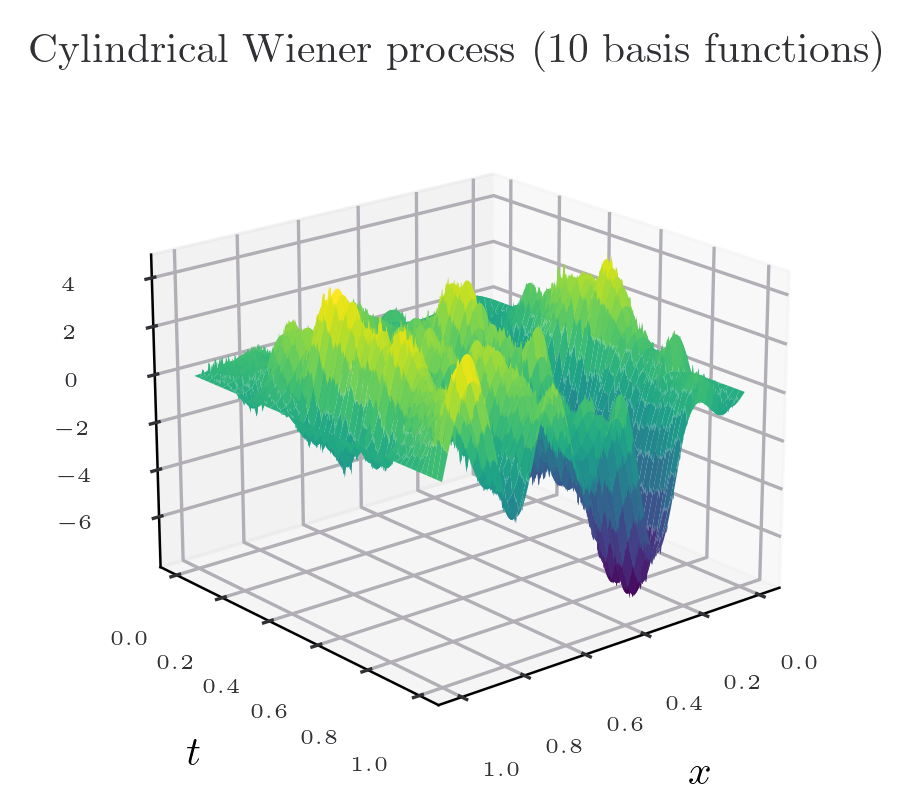

In [196]:
plt.style.use('plot_style-Examples_3d.txt')
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span)
ax.plot_surface(X, Y, wiener_process,  cmap='viridis', antialiased=True)
ax.set_title('Cylindrical Wiener process ({} basis functions)'.format(N_basis))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.savefig('figures/white_noise/st_wn.png', bbox_inches = 'tight')
plt.show()

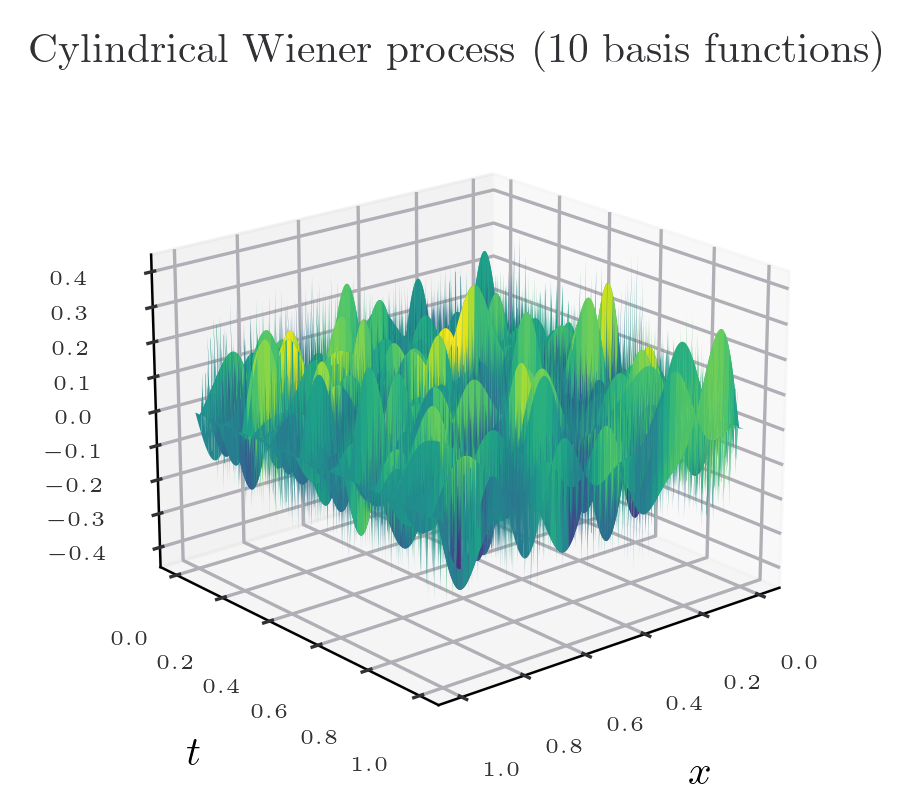

In [216]:
plt.style.use('plot_style-Examples_3d.txt')
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw={'projection': '3d'})

# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span[:-1])
ax.plot_surface(X, Y, white_noise,  cmap='viridis', antialiased=True)
ax.set_title('Cylindrical Wiener process ({} basis functions)'.format(N_basis))
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()